# 1 Financial News Headlines Sentiment Classification

**Group Member:**

- Siyang Huang - sh5958@nyu.edu
- Tianjing Cao - tc3385@nyu.edu
- Zhuoran Ma - zm2161@nyu.edu

**Introduction:**

- In this notebook, we processed financial news headlines text data from [Kaggle](https://www.kaggle.com/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests?resource=download&select=raw_partner_headlines.csv) with TF-IDF vectorizer and [pretrained BERT sentence transformer](https://www.sbert.net/docs/quickstart.html) as two different kinds of X inputs.

- With supervised machine learning models, we labeled the headlines in two ways: using corresponding stock daily returns with absolute value > 0.1 (Label Type I) or using [huggingface transformers pipeline of sentiment analysis](https://huggingface.co/docs/transformers/main_classes/pipelines) (Label Type II).

- Then, on both Label Tpyes I and II, we trained first kind of X input (TF-IDF vectorizer) with [fine-tuned Naive Bayes](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/), and second kind of X input (pretrained BERT sentence transformer) with fine-tuned Random Forest Classifier.

- Also, we tried Logistic Regression, Gaussian Naive Bayes, SVM and TCN with some default settings to compare 6 classifiers' performance (test set accuracy, ROC Curve and AUC), and output some test examples at the end.

**Notes:**
- All .csv and .pkl data files are availble in zip file. 
- If these files are downloaded and saved to current working directory, the running time will be greatly shortened.

# 2 Initial Setup

In [1]:
# import packages
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

## 2.1 Load financial news rawdata download from [Kaggle](https://www.kaggle.com/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests?resource=download&select=raw_partner_headlines.csv)

In [2]:
# load rawdata: Daily Financial News for 6000+ Stocks from 2009-2020
rawdata = pd.read_csv('raw_partner_headlines.csv', usecols=[1,4,5], parse_dates=['date'])
print("There are {} news headlines in this rawdata".format(rawdata.shape[0]))
rawdata.head()

There are 1845559 news headlines in this rawdata


,headline,date,stock
0,Agilent Technologies Announces Pricing of $5……...,2020-06-01,A
1,Agilent (A) Gears Up for Q2 Earnings: What's i...,2020-05-18,A
2,J.P. Morgan Asset Management Announces Liquida...,2020-05-15,A
3,"Pershing Square Capital Management, L.P. Buys ...",2020-05-15,A
4,Agilent Awards Trilogy Sciences with a Golden ...,2020-05-12,A


## 2.2 Check and Process financial news rawdata

In [3]:
# count the number of news in each year
rawdata.groupby([rawdata['date'].dt.year])['date'].count()

date
1969         1
2010     12879
2011     46660
2012    111395
2013     90521
2014    110163
2015    281920
2016    233045
2017    161457
2018    332601
2019    368574
2020     96343
Name: date, dtype: int64

In [4]:
# delete the one piece of news in 1969
rawdata.drop(rawdata[rawdata['date'].dt.year==1969].index, inplace=True)

In [5]:
# set start date and end date 2010-2020
start_date = min(rawdata.date)
end_date = max(rawdata.date)
print("The time range of this rawdata is from {} to {}".format(start_date, end_date))

The time range of this rawdata is from 2010-02-03 00:00:00 to 2020-06-04 00:00:00


## 2.3 Produce Y Label Type I - daily return of each stock on corresponding date as label

In [6]:
# get unique stock tickers
unique_stocks = list(rawdata['stock'].unique())
print("There are {} unique stocks in this rawdata".format(len(unique_stocks)))

There are 6552 unique stocks in this rawdata


In [7]:
# get stock close price
import yfinance as yf
if os.path.exists('stock_close_price.csv'):
    close_price = pd.read_csv('stock_close_price.csv', parse_dates=['Date'], index_col=0)
    print("<Read stock_close_price from local file>")
else:
    close_price = yf.download(unique_stocks, start=start_date, end=end_date, threads=False)['Adj Close']
    close_price.to_csv('stock_close_price.csv')
    print("<Save stock_close_price to local file>")

<Read stock_close_price from local file>


In [8]:
# get stock return label
bigreturn_threshold = 10
stock_bigreturn_filename = 'stock_bigreturn_label_'+str(bigreturn_threshold)+'.csv'

if os.path.exists(stock_bigreturn_filename):
    stock_return = pd.read_csv(stock_bigreturn_filename, parse_dates=['date'], usecols=[1,2,3])
    print("<Read {} from local file>".format(stock_bigreturn_filename))
else:
    # calculate stock daily return of the next day (Close/Close-1 as return label for training only not for trading)
    stock_return = close_price.pct_change().shift(-1)
    stock_return.head()
    # unstack stock_return and delete rows where stock_return==0
    stock_return = stock_return.unstack().reset_index()
    stock_return.columns = ['stock', 'date', 'return']
    stock_return.drop(stock_return[stock_return['return']==0].index, inplace=True)
    # mark return>0.1 as label 1 and return<-0.1 as label 0
    stock_return.loc[:, 'label'] = np.NaN
    stock_return.loc[stock_return['return']>(bigreturn_threshold/100), 'label'] = 1
    stock_return.loc[stock_return['return']<-(bigreturn_threshold/100), 'label'] = 0
    del stock_return['return']
    stock_return.dropna(inplace=True)
    stock_return['label'] = stock_return['label'].astype('int')
    # save csv file
    stock_return.to_csv(stock_bigreturn_filename)
    print("<Save {} to local file>".format(stock_bigreturn_filename))

<Read stock_bigreturn_label_10.csv from local file>


In [9]:
stock_return.tail()

,stock,date,label
115216,ZUMZ,2020-03-23,1
115217,ZUMZ,2020-03-31,0
115218,ZUMZ,2020-04-03,1
115219,ZUMZ,2020-04-06,1
115220,ZUMZ,2020-04-24,1


In [10]:
# merge financial news rawdata with stock return labels, then dropna
df = pd.merge(rawdata, stock_return, how='left', left_on=['stock','date'], right_on=['stock','date'])
df.dropna(inplace=True)
df['label'] = df['label'].astype('int')
print("There are {} news headlines in this return label data".format(df.shape[0]))
df.head()

There are 27520 news headlines in this return label data


,headline,date,stock,label
186,"Agilent Technologies, Inc. (A) CEO Mike McMull...",2019-05-14,A,0
187,"A, ACB, EGHT and TLRY among notable after hour...",2019-05-14,A,0
188,Agilent Technologies (A) Q2 Earnings and Reven...,2019-05-14,A,0
189,"Agilent down 8% after hours on FQ2 miss, reven...",2019-05-14,A,0
190,"Agilent misses by $0.01, misses on revenue",2019-05-14,A,0


## 2.4 Produce Y Label Type II - pipeline sentiment analysis of each headline as label

In [11]:
# record sentiment label and score for each headline
from transformers import pipeline
classifier = pipeline('sentiment-analysis', model='ProsusAI/finbert')
def sentiment_analysis(sentence):
    return classifier(sentence)[0]['label'], classifier(sentence)[0]['score']
        
if os.path.exists('stock_headline_sentiment.csv'):
    df = pd.read_csv('stock_headline_sentiment.csv', parse_dates=['date'], usecols=[1,2,3,4,5,6])
    print("<Read stock_headline_sentiment from local file>")
else:
    df['sentiment'] = np.NaN
    df['sentiment_score'] = np.NaN
    for i in df.index:
        label, score = sentiment_analysis(df.loc[i, 'headline'])
        df.loc[i,'sentiment'] = label
        df.loc[i,'sentiment_score'] = score
    # save csv file
    df.to_csv('stock_headline_sentiment.csv')
    print("<Save stock_headline_sentiment to local file>")
df.head()

<Read stock_headline_sentiment from local file>


,headline,date,stock,label,sentiment,sentiment_score
0,"Agilent Technologies, Inc. (A) CEO Mike McMull...",2019-05-14,A,0,neutral,0.909800
1,"A, ACB, EGHT and TLRY among notable after hour...",2019-05-14,A,0,neutral,0.808891
2,Agilent Technologies (A) Q2 Earnings and Reven...,2019-05-14,A,0,negative,0.962386
3,"Agilent down 8% after hours on FQ2 miss, reven...",2019-05-14,A,0,negative,0.969427
4,"Agilent misses by $0.01, misses on revenue",2019-05-14,A,0,negative,0.928350


In [12]:
# drop headlines with neutral sentiment labels to reduce data amount and enhance accuracy
df.dropna(inplace=True)
df.drop(df[df['sentiment']=='neutral'].index, inplace=True)
df.loc[df['sentiment']=='positive', 'sentiment_label']=1
df.loc[df['sentiment']=='negative', 'sentiment_label']=0
df['sentiment_label'] = df['sentiment_label'].astype('int')
print("There are {} news headlines in this final labels data".format(df.shape[0]))
df.head()

There are 11440 news headlines in this final labels data


,headline,date,stock,label,sentiment,sentiment_score,sentiment_label
2,Agilent Technologies (A) Q2 Earnings and Reven...,2019-05-14,A,0,negative,0.962386,0
3,"Agilent down 8% after hours on FQ2 miss, reven...",2019-05-14,A,0,negative,0.969427,0
4,"Agilent misses by $0.01, misses on revenue",2019-05-14,A,0,negative,0.928350,0
6,"Alcoa Corp. (AA) Reports Q4 Loss, Misses Reven...",2020-01-15,AA,0,negative,0.972504,0
9,Mmtec leads financial gainers; Enova Internati...,2019-11-15,AAME,0,positive,0.785719,1


In [13]:
#df.sample(100).to_excel('Data_Example.xlsx')

#  3 Baseline Model 1: TF-IDF + Naive Bayes Classifier
## 3.1 Y Label - daily stock return as label

In [14]:
# train_validate_test_split by actual dates
start_date = min(df.date)
end_date = max(df.date)
print("The time range of this rawdata is from {} to {}".format(start_date, end_date))
train_period = (df['date']>='2010-02-03') & (df['date']<'2018-11-01')
val_period = (df['date']>='2018-11-01') & (df['date']<'2019-06-02')
test_period = (df['date']>='2019-06-02') & (df['date']<='2020-06-02')

The time range of this rawdata is from 2010-02-03 00:00:00 to 2020-06-02 00:00:00


In [15]:
# train_validate_test_split by actual dates
X_train = df[train_period]['headline'].values
X_val = df[val_period]['headline'].values
X_test = df[test_period]['headline'].values

y_train = df[train_period]['label'].values.astype('int')
y_val = df[val_period]['label'].values.astype('int')
y_test = df[test_period]['label'].values.astype('int')

print("The size of train, validation and test set are", [len(x) for x in [X_train, X_val, X_test]])

The size of train, validation and test set are [6738, 1525, 3177]


## 3.2 Text pre-processing and Vectorization

In [16]:
# ! pip install contractions

In [17]:
import contractions
import string
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

lemmatizer = WordNetLemmatizer()
Stemmer = PorterStemmer()

def lemmatize_sentence(s):
    return " ".join([lemmatizer.lemmatize(word) for word in s.split(' ')])

def stem_sentence(s):
    return " ".join([Stemmer.stem(word) for word in s.split(' ')])

def text_preprocessing(s):
    # 1. Expand Contractions
    s = contractions.fix(s)
    # 2. Lowercase
    s = s.lower()
    # 3. Remove Punctuations
    s = re.sub(r"\'s", "", s)
    s = re.sub('[%s]' % re.escape(string.punctuation), ' ', s)
    # 4. Remove Digits
    s = re.sub('\d',' ', s)
    # 5. Lemmatization
    s = lemmatize_sentence(s)
    # 6. Stemming (Not applied here to prevent some new error)
    # s = stem_sentence(s)
    # 7. Remove Extra Whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/huangsiyang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess financial news text
X_train_preprocessed = np.array([text_preprocessing(sentence) for sentence in X_train])
X_val_preprocessed = np.array([text_preprocessing(sentence) for sentence in X_val])
X_test_preprocessed = np.array([text_preprocessing(sentence) for sentence in X_test])

# Calculate TF-IDF Vectorizer with stop_words removed
tf_idf = TfidfVectorizer(analyzer='word',
                         ngram_range=(1, 3),
                         smooth_idf=False,
                         stop_words='english')
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

## 3.3 Train classifier and Hyperparameter tuning with Cross validation

In [19]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  3.4


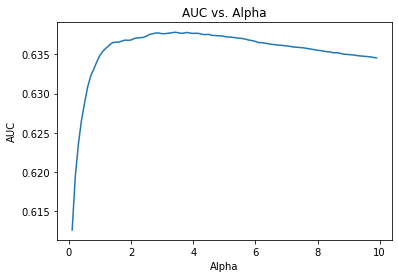

Total # of the train cases is 6738.


In [20]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(alpha=i)) for i in np.arange(0.1, 10, 0.1)], index=np.arange(0.1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

# debug / info
print("Total # of the train cases is {}.".format(len(y_train)))

## 3.4 Evaluation on Validation Set

In [21]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # debug / info
    print("Total # of the validation cases is {}.".format(len(y_val)))

alpha = 3.4
AUC: 0.6516
Accuracy: 57.97%


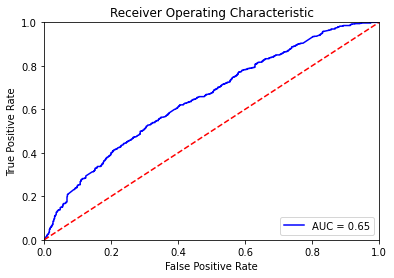

Total # of the validation cases is 1525.


In [22]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=3.4)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
print('alpha = 3.4')
evaluate_roc(probs, y_val)

## 3.5 Report on Test Set

In [23]:
# Some quantitative test functions
def calculate_confusion_matrix_and_report(y_predicted, y_golden, with_plot=True):
    """
        Returns the confusion matrix with plot and a quantitative assessment of model performances
        For now, we just re-use the built-in classification_report from sklearn
    """
    from sklearn.metrics import confusion_matrix, classification_report
    import pandas as pd

    # calculate confusion matrix
    cm = confusion_matrix(y_golden, y_predicted)
    # plot the matrix
    if with_plot:
        plot_confusion_matrix(cm)
    # build a readable report
    class_rpt = classification_report(y_golden, y_predicted, output_dict=True)
    class_rpt = pd.DataFrame(class_rpt).transpose()
    class_rpt.index.name = 'Labels & Scores'

    # print out the confusion matrix and classification report
    print('\n====== Confusion Matrix ======')
    print(cm)
    print('\n====== Classification Report ======')
    print(class_rpt)

    return cm, class_rpt


def plot_confusion_matrix(c_matrix):
    import matplotlib.pyplot as plt
    plt.imshow(c_matrix, cmap='Purples')
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("Confusion matrix")
    plt.colorbar()
    plt.show()

    return

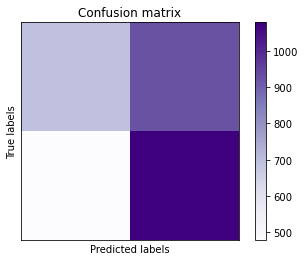


====== Confusion Matrix ======
[[ 694  925]
 [ 479 1079]]

====== Classification Report ======
                 precision    recall  f1-score      support
Labels & Scores                                            
0                 0.591645  0.428660  0.497135  1619.000000
1                 0.538423  0.692555  0.605839  1558.000000
accuracy          0.558074  0.558074  0.558074     0.558074
macro avg         0.565034  0.560607  0.551487  3177.000000
weighted avg      0.565545  0.558074  0.550443  3177.000000
Total # of the test cases is 3177.


In [24]:
y_predicted = nb_model.predict(X_test_tfidf)
confusion_matrix, class_report = calculate_confusion_matrix_and_report(y_predicted, y_test)
# debug / info
print("Total # of the test cases is {}.".format(len(y_test)))

# 4 Baseline Model 2: TF-IDF + Naive Bayes Classifier
## 4.1 Y Label - sentiment analysis as label

In [25]:
# train_validate_test_split by actual dates
X_train = df[train_period]['headline'].values
X_val = df[val_period]['headline'].values
X_test = df[test_period]['headline'].values

y_train = df[train_period]['sentiment_label'].values.astype('int')
y_val = df[val_period]['sentiment_label'].values.astype('int')
y_test = df[test_period]['sentiment_label'].values.astype('int')

print("The size of train, validation and test set are", [len(x) for x in [X_train, X_val, X_test]])

The size of train, validation and test set are [6738, 1525, 3177]


## 4.2 Train Classifier and Hyperparameter tuning with Cross validation

Best alpha:  0.7


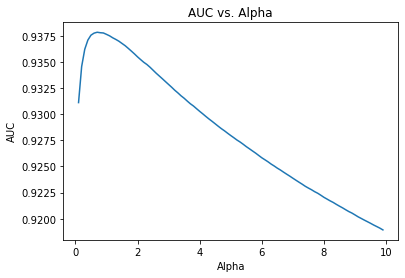

Total # of the train cases is 6738.


In [26]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(alpha=i)) for i in np.arange(0.1, 10, 0.1)], index=np.arange(0.1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

# debug / info
print("Total # of the train cases is {}.".format(len(y_train)))

## 4.3 Evaluation on Validation Set

alpha = 0.7
AUC: 0.9423
Accuracy: 86.56%


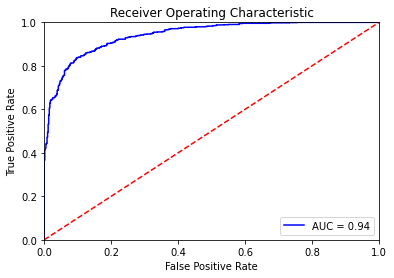

Total # of the validation cases is 1525.


In [27]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=0.7)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
print('alpha = 0.7')
evaluate_roc(probs, y_val)

## 4.4 Report on Test Set

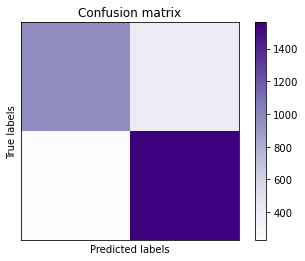


====== Confusion Matrix ======
[[ 963  423]
 [ 231 1560]]

====== Classification Report ======
                 precision    recall  f1-score      support
Labels & Scores                                            
0                 0.806533  0.694805  0.746512  1386.000000
1                 0.786687  0.871022  0.826709  1791.000000
accuracy          0.794145  0.794145  0.794145     0.794145
macro avg         0.796610  0.782913  0.786610  3177.000000
weighted avg      0.795345  0.794145  0.791722  3177.000000
Total # of the test cases is 3177.


In [28]:
y_predicted = nb_model.predict(X_test_tfidf)
y_prob_nb_model = nb_model.predict_proba(X_test_tfidf)[:,1]

confusion_matrix, class_report = calculate_confusion_matrix_and_report(y_predicted, y_test)
# debug / info
print("Total # of the test cases is {}.".format(len(y_test)))

In [29]:
# from tqdm import tqdm
# from sklearn.metrics import f1_score

# def threshold_search(y_true, y_proba):
#     best_threshold = 0
#     best_score = 0
#     for threshold in tqdm([i * 0.01 for i in range(100)], disable=True):
#         score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
#         if score > best_score:
#             best_threshold = threshold
#             best_score = score
#     search_result = {'threshold': best_threshold, 'f1': best_score}
#     return search_result

# y_probs = nb_model.predict_proba(X_test_tfidf)[:,1]
# threshold_search(y_test, y_probs)

# y_predicted = (y_probs > 0.7).astype(int)
# calculate_confusion_matrix_and_report(y_predicted, y_test)

# 5 BERT Model 1: SentenceTransformer + Random Forest
## 5.1 Y Label - daily stock return as label

In [30]:
# train_validate_test_split by actual dates
X_train = df[train_period]['headline'].values
X_val = df[val_period]['headline'].values
X_test = df[test_period]['headline'].values

y_train = df[train_period]['label'].values.astype('int')
y_val = df[val_period]['label'].values.astype('int')
y_test = df[test_period]['label'].values.astype('int')

print("The size of train, validation and test set are", [len(x) for x in [X_train, X_val, X_test]])

The size of train, validation and test set are [6738, 1525, 3177]


## 5.2 Transform X (headlines) using pretrained BERT into vectors

In [31]:
import os
import pickle
Final_Folder = os.getcwd()
if os.path.exists('bert_w2vec_X_val.pkl'):
    Re_Transform = 0
    print("<Read bert_w2vec_X_val from local file>")
else:
    Re_Transform = 1
    print("<Re-Transform bert_w2vec_X_val needed>")

<Read bert_w2vec_X_val from local file>


In [32]:
# Some sentence processing and vectorizing function
def bert_sentence_encoding(sentences, model):
    embedded_sentences = model.encode(sentences)
    return embedded_sentences

def bert_w2vec_X(X, sentence_model, Final_Folder: str, X_type: str):
    import pickle
    bert_w2vec_X = np.array(bert_sentence_encoding(X, sentence_model))
    pickle.dump(bert_w2vec_X, open(os.path.join(Final_Folder, f'bert_w2vec_X_{X_type}.pkl'), 'wb+'))
    print(f"bert_w2vec_X_{X_type} vectorize finished")
    return bert_w2vec_X

In [33]:
from sentence_transformers import SentenceTransformer

# load local bert vector data
if Re_Transform == 0:
    print('<Read BERT pkl from local file>')
    bert_w2vec_X_train = pickle.load(open(os.path.join(Final_Folder,'bert_w2vec_X_train.pkl'), 'rb+'))
    bert_w2vec_X_test = pickle.load(open(os.path.join(Final_Folder,'bert_w2vec_X_test.pkl'), 'rb+'))
    bert_w2vec_X_val = pickle.load(open(os.path.join(Final_Folder,'bert_w2vec_X_val.pkl'), 'rb+'))
# recalculate bert vector data and dump pickle
else:
    print('<Reproduce BERT pkl and save to file>')
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
    bert_w2vec_X_train = bert_w2vec_X(X_train, sentence_model, Final_Folder, "train")
    bert_w2vec_X_test = bert_w2vec_X(X_test, sentence_model, Final_Folder, "test")
    bert_w2vec_X_val = bert_w2vec_X(X_val, sentence_model, Final_Folder, "val")
# debug / info
print("Shapes of bert_w2vec_X_train, bert_w2vec_X_test and bert_w2vec_X_val are: "
      "{}, {} and {}.".format(bert_w2vec_X_train.shape, bert_w2vec_X_test.shape, bert_w2vec_X_val.shape))

<Read BERT pkl from local file>
Shapes of bert_w2vec_X_train, bert_w2vec_X_test and bert_w2vec_X_val are: (6738, 384), (3177, 384) and (1525, 384).


## 5.3 Train classifier and Hyperparameter tuning with Cross Validation

In [34]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(model, bert_w2vec_X_train, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best max_depth:  5


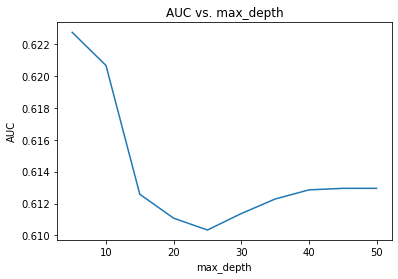

Total # of the train cases is 6738.


In [35]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics

res = []
for i in np.arange(5,55,5):
    model = RandomForestClassifier(n_estimators=200, max_depth=i, random_state=0, n_jobs=-1)
    res.append(get_auc_CV(model))
res = pd.Series(res, index=np.arange(5,55,5))

best_max_depth = np.round(res.idxmax(), 2)
print('Best max_depth: ', best_max_depth)

plt.plot(res)
plt.title('AUC vs. max_depth')
plt.xlabel('max_depth')
plt.ylabel('AUC')
plt.show()

# debug / info
print("Total # of the train cases is {}.".format(len(y_train)))

Best n_estimators:  300


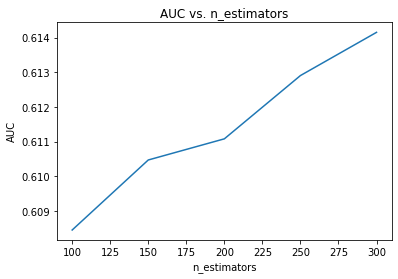

Total # of the train cases is 6738.


In [36]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics

res = []
for i in np.arange(100, 350, 50):
    model = RandomForestClassifier(n_estimators=i, max_depth=20, random_state=0, n_jobs=-1)
    res.append(get_auc_CV(model))
res = pd.Series(res, index=np.arange(100, 350, 50))

best_max_depth = np.round(res.idxmax(), 2)
print('Best n_estimators: ', best_max_depth)

plt.plot(res)
plt.title('AUC vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.show()

# debug / info
print("Total # of the train cases is {}.".format(len(y_train)))

## 5.4 Evaluation on Validation Set

n_estimators=300, max_depth=5
AUC: 0.6380
Accuracy: 58.43%


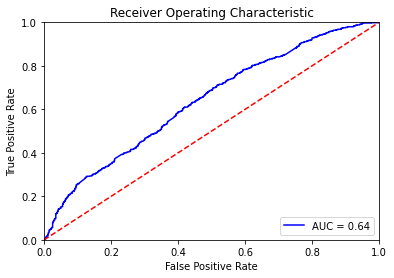

Total # of the validation cases is 1525.


In [37]:
# Compute predicted probabilities
rf_model = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=0, n_jobs=-1)
rf_model.fit(bert_w2vec_X_train, y_train)
probs = rf_model.predict_proba(bert_w2vec_X_val)

# Evaluate the classifier
print('n_estimators=300, max_depth=5')
evaluate_roc(probs, y_val)

## 5.5 Report on Test Set

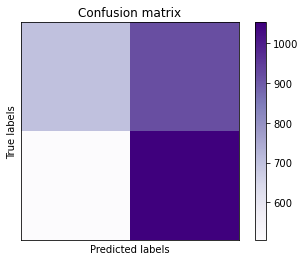


====== Confusion Matrix ======
[[ 701  918]
 [ 506 1052]]

====== Classification Report ======
                 precision    recall  f1-score      support
Labels & Scores                                            
0                 0.580779  0.432983  0.496108  1619.000000
1                 0.534010  0.675225  0.596372  1558.000000
accuracy          0.551778  0.551778  0.551778     0.551778
macro avg         0.557394  0.554104  0.546240  3177.000000
weighted avg      0.557843  0.551778  0.545277  3177.000000
Total # of the test cases is 3177.


In [38]:
y_predicted = rf_model.predict(bert_w2vec_X_test)
confusion_matrix, class_report = calculate_confusion_matrix_and_report(y_predicted, y_test)
# debug / info
print("Total # of the test cases is {}.".format(len(y_test)))

# 6 BERT Model 2: SentenceTransformer + Random Forest
## 6.1 Y Label - sentiment analysis as label

In [39]:
# train_validate_test_split by actual dates
X_train = df[train_period]['headline'].values
X_val = df[val_period]['headline'].values
X_test = df[test_period]['headline'].values

y_train = df[train_period]['sentiment_label'].values.astype('int')
y_val = df[val_period]['sentiment_label'].values.astype('int')
y_test = df[test_period]['sentiment_label'].values.astype('int')

print("The size of train, validation and test set are", [len(x) for x in [X_train, X_val, X_test]])

The size of train, validation and test set are [6738, 1525, 3177]


## 6.2 Train classifier and Hyperparameter tuning with Cross Validation

Best max_depth:  15


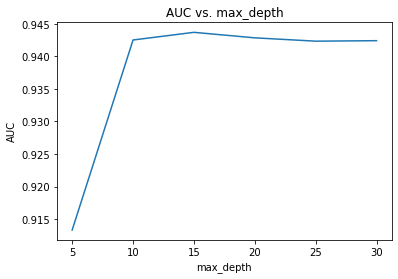

Total # of the train cases is 6738.


In [40]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics

res = []
for i in np.arange(5,35,5):
    model = RandomForestClassifier(n_estimators=200, max_depth=i, random_state=0, n_jobs=-1)
    res.append(get_auc_CV(model))
res = pd.Series(res, index=np.arange(5,35,5))

best_max_depth = np.round(res.idxmax(), 2)
print('Best max_depth: ', best_max_depth)

plt.plot(res)
plt.title('AUC vs. max_depth')
plt.xlabel('max_depth')
plt.ylabel('AUC')
plt.show()

# debug / info
print("Total # of the train cases is {}.".format(len(y_train)))

Best n_estimators:  300


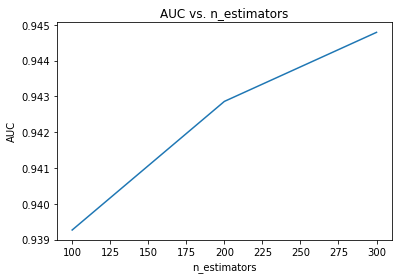

Total # of the train cases is 6738.


In [41]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics

res = []
for i in np.arange(100, 350, 100):
    model = RandomForestClassifier(n_estimators=i, max_depth=20, random_state=0, n_jobs=-1)
    res.append(get_auc_CV(model))
res = pd.Series(res, index=np.arange(100, 350, 100))

best_max_depth = np.round(res.idxmax(), 2)
print('Best n_estimators: ', best_max_depth)

plt.plot(res)
plt.title('AUC vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.show()

# debug / info
print("Total # of the train cases is {}.".format(len(y_train)))

## 6.3 Evaluation on Validation Set

n_estimators=300, max_depth=15
AUC: 0.9441
Accuracy: 88.39%


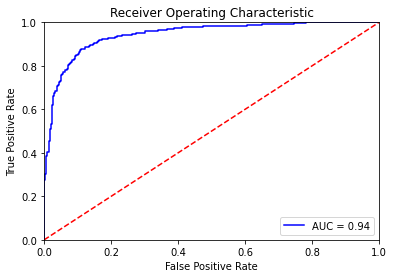

Total # of the validation cases is 1525.


In [42]:
# Compute predicted probabilities
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=0, n_jobs=-1)
rf_model.fit(bert_w2vec_X_train, y_train)
probs = rf_model.predict_proba(bert_w2vec_X_val)

# Evaluate the classifier
print('n_estimators=300, max_depth=15')
evaluate_roc(probs, y_val)

## 6.4 Report on Test Set

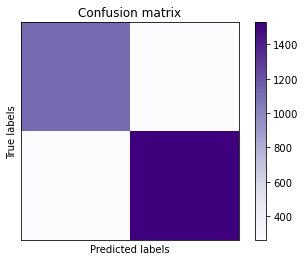


====== Confusion Matrix ======
[[1122  264]
 [ 263 1528]]

====== Classification Report ======
                 precision    recall  f1-score     support
Labels & Scores                                           
0                 0.810108  0.809524  0.809816  1386.00000
1                 0.852679  0.853155  0.852917  1791.00000
accuracy          0.834120  0.834120  0.834120     0.83412
macro avg         0.831393  0.831339  0.831366  3177.00000
weighted avg      0.834107  0.834120  0.834113  3177.00000
Total # of the test cases is 3177.


In [43]:
y_predict = rf_model.predict(bert_w2vec_X_test)
y_prob_rf_model = rf_model.predict_proba(bert_w2vec_X_test)[:,1]
confusion_matrix, class_report = calculate_confusion_matrix_and_report(y_predict, y_test)
# debug / info
print("Total # of the test cases is {}.".format(len(y_test)))

# 7 Try some other models on Label Type II

## 7.1 Logistic regression

In [44]:
# BERT
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc

lr = LogisticRegression(random_state = 0, n_jobs = -1, solver = 'lbfgs')
lr.fit(bert_w2vec_X_train, y_train)
y_predict = lr.predict(bert_w2vec_X_test)
y_prob_lr = lr.predict_proba(bert_w2vec_X_test)[:,1]
print('accuracy = ', accuracy_score(y_test, y_predict))
print('auc = ', roc_auc_score(y_test, y_predict))

accuracy =  0.8681145734970097
auc =  0.8669556295184436


In [45]:
# TF_IDF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc

lr = LogisticRegression(random_state = 0, n_jobs = -1, solver = 'lbfgs')
lr.fit(X_train_tfidf, y_train)
y_predict = lr.predict(X_test_tfidf)

print('accuracy = ', accuracy_score(y_test, y_predict))
print('auc = ', roc_auc_score(y_test, y_predict))

accuracy =  0.8016997167138811
auc =  0.7982607844416891


## 7.2 Gaussian naive bayes

In [46]:
# TF_IDF
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_tfidf.toarray(), y_train)
y_predict = nb.predict(X_test_tfidf.toarray())
y_prob_nb = nb.predict_proba(X_test_tfidf.toarray())[:,1]
print('accuracy = ', accuracy_score(y_test, y_predict))
print('auc = ', roc_auc_score(y_test, y_predict))

accuracy =  0.7031790997796663
auc =  0.7112057401002124


In [47]:
# BERT
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(bert_w2vec_X_train, y_train)
y_predict = nb.predict(bert_w2vec_X_test)
print('accuracy = ', accuracy_score(y_test, y_predict))
print('auc = ', roc_auc_score(y_test, y_predict))

accuracy =  0.6474661630468996
auc =  0.6742732421124381


## 7.3 Support Vector Machine

In [48]:
# TF_IDF
from sklearn.svm import SVC
svm = SVC(kernel='rbf', probability=True, random_state=0)
svm.fit(X_train_tfidf, y_train)
y_predict = svm.predict(X_test_tfidf)
print('accuracy = ', accuracy_score(y_test, y_predict))
print('auc = ', roc_auc_score(y_test, y_predict))

accuracy =  0.817752596789424
auc =  0.8140485979681961


In [49]:
# BERT
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=1, probability=True, random_state=0)
svm.fit(bert_w2vec_X_train, y_train)
y_predict = svm.predict(bert_w2vec_X_test)
y_prob_svm = svm.predict_proba(bert_w2vec_X_test)[:,1]
print('accuracy = ', accuracy_score(y_test, y_predict))
print('auc = ', roc_auc_score(y_test, y_predict))

accuracy =  0.8772426817752597
auc =  0.8757858556853533


## 7.4 Temporal Convolutional Network

In [50]:
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Functional API
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [51]:
# Get the number of unique labels
num_cases = np.unique(y_train).shape[0]

if num_cases > 2:
    activation = "softmax"
    loss = 'categorical_crossentropy'
else:
    activation = "sigmoid"
    num_cases = 1
    loss = 'binary_crossentropy'
print('The loss function is', loss)

The loss function is binary_crossentropy


In [52]:
# ! pip install keras-tcn

In [53]:
from tcn import TCN

### 7.4.1 BERT Transformer

In [54]:
# reshape
X_train_0 = bert_w2vec_X_train.reshape([bert_w2vec_X_train.shape[0],1,bert_w2vec_X_train.shape[1]])
X_val_0 = bert_w2vec_X_val.reshape([bert_w2vec_X_val.shape[0],1,bert_w2vec_X_val.shape[1]])
X_test_0 = bert_w2vec_X_test.reshape([bert_w2vec_X_test.shape[0],1,bert_w2vec_X_test.shape[1]])
X_train_0.shape

(6738, 1, 384)

In [55]:
batch_size, time_steps, input_dim = None, X_train_0.shape[1], X_train_0.shape[2]
tcn_layer = TCN(input_shape = (time_steps, input_dim))
model1 = Sequential([tcn_layer, 
                     Dense(1), 
                     Dropout(0.5), 
                     Dense(num_cases, activation=activation)])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [56]:
def acc_key(history=None, model=None):
    key_name = None
    
    if model is not None:
      key_name = "accuracy" if "accuracy" in model.metrics_names else "acc"
    else:
      key_name = "accuracy" if "accuracy" in history.history.keys() else "acc"
    
    return key_name


def TCN_plotTrain(history, model_name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5) )

    # Determine the name of the key that indexes into the accuracy metric
    acc_string = acc_key(history=history)
    
    # Plot loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model_name + " " + 'model loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'validation'], loc='upper left')
   
    # Plot accuracy
    axs[1].plot(history.history[ acc_string ])
    axs[1].plot(history.history['val_' + acc_string ])
    axs[1].set_title(model_name + " " +'model accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'validation'], loc='upper left')

    return fig, axs

In [57]:
model_name1 = "TCN + BERT"
max_epochs = 10
batch_size = 200
history1=model1.fit(X_train_0, y_train,
            batch_size=batch_size,
            epochs=max_epochs,
            verbose=1,
            validation_data=(X_val_0, y_val)
            )

Epoch 1/10
34/34 [==============================] - 4s 77ms/step - loss: 0.5795 - accuracy: 0.6687 - val_loss: 0.3608 - val_accuracy: 0.8852
Epoch 2/10
34/34 [==============================] - 2s 44ms/step - loss: 0.4995 - accuracy: 0.7205 - val_loss: 0.3312 - val_accuracy: 0.8859
Epoch 3/10
34/34 [==============================] - 2s 44ms/step - loss: 0.4672 - accuracy: 0.7407 - val_loss: 0.3148 - val_accuracy: 0.8898
Epoch 4/10
34/34 [==============================] - 2s 45ms/step - loss: 0.4604 - accuracy: 0.7437 - val_loss: 0.3188 - val_accuracy: 0.9010
Epoch 5/10
34/34 [==============================] - 2s 44ms/step - loss: 0.4546 - accuracy: 0.7496 - val_loss: 0.3037 - val_accuracy: 0.8984
Epoch 6/10
34/34 [==============================] - 2s 45ms/step - loss: 0.4481 - accuracy: 0.7474 - val_loss: 0.3075 - val_accuracy: 0.8938
Epoch 7/10
34/34 [==============================] - 2s 47ms/step - loss: 0.4361 - accuracy: 0.7573 - val_loss: 0.3022 - val_accuracy: 0.8911
Epoch 8/10
34

In [58]:
score1 = []
score1 = model1.evaluate(X_test_0, y_test, verbose=0)
y_prob_tcn = model1.predict(X_test_0)
print("{n:s}: Test loss: {l:f} / Test accuracy: {a:f}".format(n=model_name1, l=score1[0], a=score1[1]))

TCN + BERT: Test loss: 0.362108 / Test accuracy: 0.836324


(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'TCN + BERT model loss'}, xlabel='epoch', ylabel='loss'>,
        <AxesSubplot:title={'center':'TCN + BERT model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

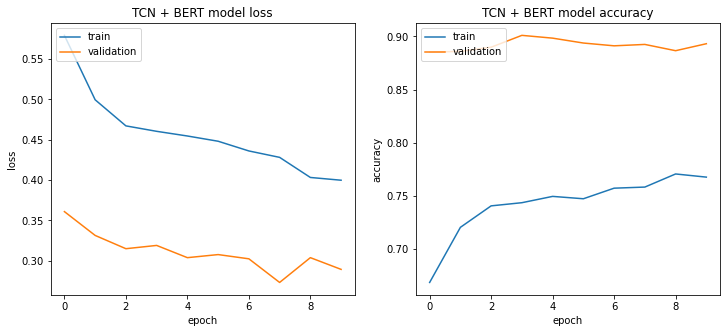

In [59]:
TCN_plotTrain(history1, model_name1)

### 7.4.2 TF-IDF Vectorizer

In [60]:
# reshape
X_train_1 = X_train_tfidf.toarray().reshape([X_train_tfidf.shape[0],1,X_train_tfidf.shape[1]])
X_val_1 = X_val_tfidf.toarray().reshape([X_val_tfidf.shape[0],1,X_val_tfidf.shape[1]])
X_test_1 = X_test_tfidf.toarray().reshape([X_test_tfidf.shape[0],1,X_test_tfidf.shape[1]])
X_train_1.shape

(6738, 1, 44663)

In [61]:
batch_size, time_steps, input_dim = None, X_train_1.shape[1], X_train_1.shape[2]
tcn_layer = TCN(input_shape = (time_steps, input_dim))
model2 = Sequential([tcn_layer, 
                     Dense(1), 
                     Dropout(0.5), 
                     Dense(num_cases, activation=activation)])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [62]:
model_name2 = "TCN + TF-IDF"
max_epochs = 10
batch_size = 200
history2=model2.fit(X_train_1, y_train,
            batch_size=batch_size,
            epochs=max_epochs,
            verbose=1,
            validation_data=(X_val_1, y_val)
            )

Epoch 1/10
34/34 [==============================] - 48s 1s/step - loss: 0.5994 - accuracy: 0.6497 - val_loss: 0.3613 - val_accuracy: 0.8557
Epoch 2/10
34/34 [==============================] - 46s 1s/step - loss: 0.4388 - accuracy: 0.7505 - val_loss: 0.3272 - val_accuracy: 0.8485
Epoch 3/10
34/34 [==============================] - 46s 1s/step - loss: 0.3953 - accuracy: 0.7692 - val_loss: 0.3110 - val_accuracy: 0.8616
Epoch 4/10
34/34 [==============================] - 45s 1s/step - loss: 0.3727 - accuracy: 0.7799 - val_loss: 0.3118 - val_accuracy: 0.8610
Epoch 5/10
34/34 [==============================] - 46s 1s/step - loss: 0.3593 - accuracy: 0.7878 - val_loss: 0.3110 - val_accuracy: 0.8584
Epoch 6/10
34/34 [==============================] - 46s 1s/step - loss: 0.3434 - accuracy: 0.7965 - val_loss: 0.3248 - val_accuracy: 0.8630
Epoch 7/10
34/34 [==============================] - 46s 1s/step - loss: 0.3448 - accuracy: 0.7955 - val_loss: 0.2931 - val_accuracy: 0.8669
Epoch 8/10
34/34 [==

In [63]:
score2 = []
score2 = model2.evaluate(X_test_1, y_test, verbose=0)
print("{n:s}: Test loss: {l:f} / Test accuracy: {a:f}".format(n=model_name2, l=score2[0], a=score2[1]))

TCN + TF-IDF: Test loss: 0.466535 / Test accuracy: 0.802329


(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'TCN + TF-IDF model loss'}, xlabel='epoch', ylabel='loss'>,
        <AxesSubplot:title={'center':'TCN + TF-IDF model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

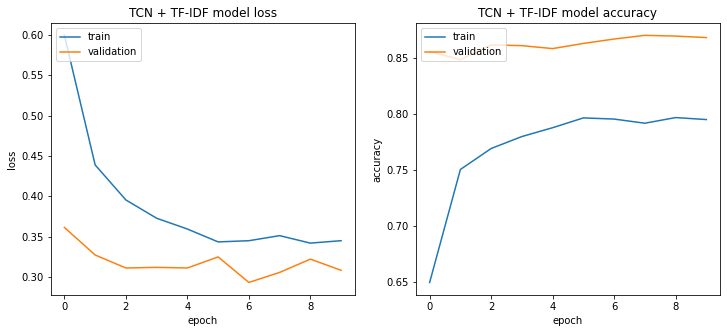

In [64]:
TCN_plotTrain(history2, model_name2)

# 8 Compare the model performances by ROC Curve

Text(0.5, 0, 'False Positive Rate')

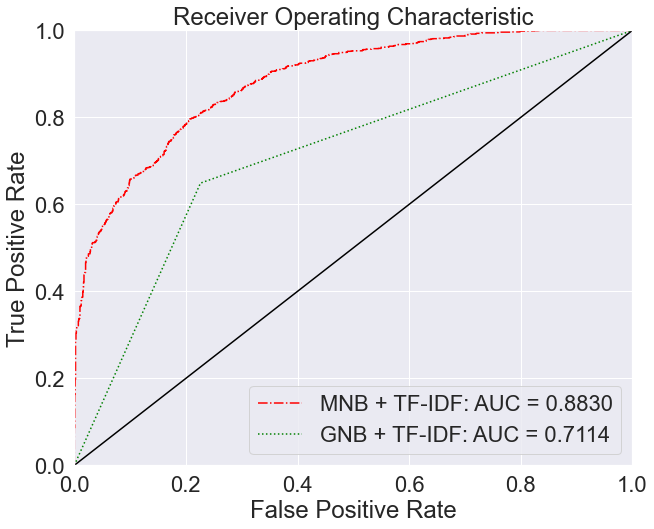

In [65]:
# ====================plot setting ===============
pd.options.display.max_colwidth = 60

plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=2)

# ===================compare ROC curves===================== 
# Compute ROC curve AUC
from sklearn.metrics import roc_curve, auc
fpr_rf_model, tpr_rf_model, _ = roc_curve(y_test, y_prob_rf_model, pos_label=None)
fpr_nb_model, tpr_nb_model, _ = roc_curve(y_test, y_prob_nb_model, pos_label=None)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr, pos_label=None)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb, pos_label=None)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm, pos_label=None)
fpr_tcn, tpr_tcn, _ = roc_curve(y_test, y_prob_tcn, pos_label=None)

roc_auc_rf_model = roc_auc_score(y_test, y_prob_rf_model)
roc_auc_nb_model = roc_auc_score(y_test, y_prob_nb_model)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
roc_auc_nb = roc_auc_score(y_test, y_prob_nb)
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
roc_auc_tcn = roc_auc_score(y_test, y_prob_tcn)

# Plot the ROC curves
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_nb_model, tpr_nb_model, 'r-.', label = 'MNB + TF-IDF: AUC = %0.4f' % roc_auc_nb_model)
plt.plot(fpr_nb, tpr_nb, 'g:', label = 'GNB + TF-IDF: AUC = %0.4f' % roc_auc_nb)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Text(0.5, 0, 'False Positive Rate')

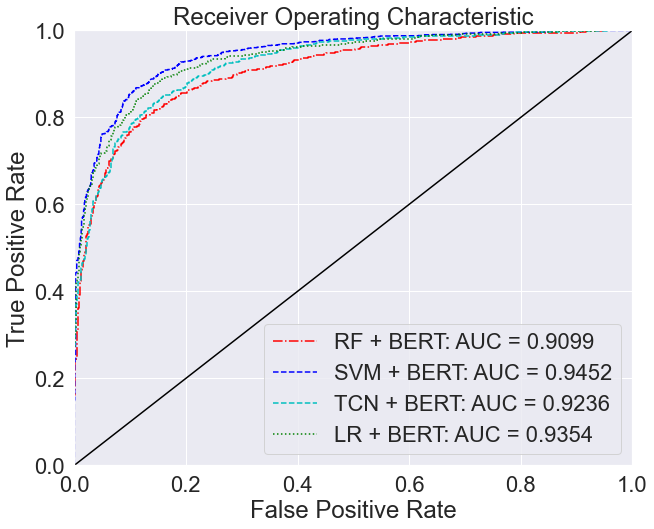

In [66]:
# Plot the ROC curves
plt.title('Receiver Operating Characteristic')

plt.plot(fpr_rf_model, tpr_rf_model, 'r-.', label = 'RF + BERT: AUC = %0.4f' % roc_auc_rf_model)
plt.plot(fpr_svm, tpr_svm, 'b--', label = 'SVM + BERT: AUC = %0.4f' % roc_auc_svm)
plt.plot(fpr_tcn, tpr_tcn, 'c--', label = 'TCN + BERT: AUC = %0.4f' % roc_auc_tcn)
plt.plot(fpr_lr, tpr_lr, 'g:', label = 'LR + BERT: AUC = %0.4f' % roc_auc_lr)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# 9 Examples of Sentiment Classification on Financial News Headlines 

In [67]:
X_example = np.array(X_test[-20:])
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
bert_w2vec_X_example = bert_w2vec_X(X_example, sentence_model, Final_Folder, "example")
svm_predicted_label = svm.predict(bert_w2vec_X_example)

bert_w2vec_X_example vectorize finished


In [68]:
X_example = X_test[-20:]
X_example_tfidf = X_test_tfidf[-20:]
lr_predicted_label = lr.predict(X_example_tfidf)
df_example = pd.DataFrame([X_example, lr_predicted_label, svm_predicted_label]).T
df_example.columns = ['Headline', 'LR', 'SVM']

In [69]:
df_example

,Headline,LR,SVM
0,"Yelp +10% amid revenue beat, strong Q4 guidance",1,1
1,"Yelp EPS misses by $0.05, beats on revenue",0,0
2,Dow Jones Industrial Average Pops After The Latest Trade...,0,1
3,China responds to new U.S. tariff threat,0,0
4,"JOYY (YY) Q4 Earnings Beat Estimates, Revenues Rise Y/Y",1,1
5,"Dow Jones Futures: Apple, AMD Lead Key Earnings Movers; ...",0,0
6,Will Portfolio Strength & User Growth Aid MSCI Q2 Earnings?,1,1
7,Buy 6 Top Stocks Set to Beat on Earnings in Q2 Today,1,1
8,Zogenix Announces Positive Top-line Results from Global ...,1,1
9,Zynga (ZNGA) Q4 Earnings Miss Estimates,0,0


In [70]:
df_example[df_example['LR']!=df_example['SVM']]

,Headline,LR,SVM
2,Dow Jones Industrial Average Pops After The Latest Trade...,0,1
16,American Eagle (AEO) Slumps Despite Q2 Earnings & Sales ...,1,0


# 10 Quantitative Trading Strategy with Label Type II

In [71]:
plt.rcParams['legend.fontsize'] = 'x-small'
plt.rcParams['axes.labelsize'] = 'x-small'
plt.rcParams['axes.titlesize'] = 'x-small'
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = 'x-small'
plt.rcParams['figure.figsize'] = (8, 4)

In [72]:
# train_validate_test_split by actual dates
X_train = df[train_period]['headline'].values
X_val = df[val_period]['headline'].values
X_test = df[test_period]['headline'].values

y_train = df[train_period]['sentiment_label'].values.astype('int')
y_val = df[val_period]['sentiment_label'].values.astype('int')
y_test = df[test_period]['sentiment_label'].values.astype('int')

print("The size of train, validation and test set are", [len(x) for x in [X_train, X_val, X_test]])

The size of train, validation and test set are [6738, 1525, 3177]


In [73]:
# Get the next day return for all stocks (Rerturn = Close/Open-1 for actual trading)
if os.path.exists('stock_all_return.csv'):
    stock_return_all = pd.read_csv('stock_all_return.csv', parse_dates=['Date'])
    stock_return_all.set_index('Date', inplace=True)
    print("<Read {} from local file>".format('stock_all_return.csv'))
    # unstack stock_return
    stock_return_all = stock_return_all.shift(-1)
    stock_return_all = stock_return_all.unstack().reset_index()
    stock_return_all.columns = ['stock', 'date', 'next_day_return']

stock_return_all.head()

<Read stock_all_return.csv from local file>


,stock,date,next_day_return
0,A,2010-02-03,-0.007850
1,A,2010-02-04,0.008993
2,A,2010-02-05,-0.000342
3,A,2010-02-08,-0.004064
4,A,2010-02-09,-0.007128


[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'S&P 500 Benchmark'}, xlabel='Date', ylabel='Cumulative Return'>

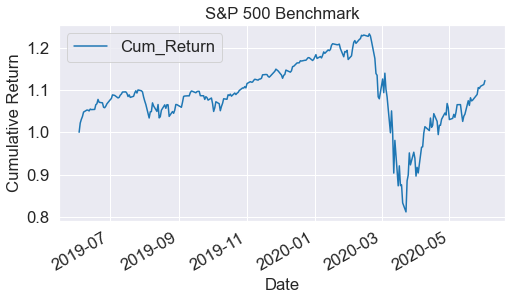

In [74]:
# S&P 500 as Benchmark
df_SP500 = yf.download('SPY', start='2019-06-01', end='2020-06-03')
df_SP500['Daily_Return'] = df_SP500.Close.pct_change().fillna(0)
df_SP500['Cum_Return'] = (df_SP500['Daily_Return']+1).cumprod()
df_SP500['Cum_Return'].plot(legend=['S&P_500'], ylabel='Cumulative Return', title='S&P 500 Benchmark')

## 10.1 Construct and Backtest 3 Signals of Trading Strategy 

### 10.1.1 Voting to determine signal for each stock that have multiple signals in one day
- signal_sum: add up all headlines' signals for each stock in one day
- signal_0: when news appears, long one unit stock on that day
- signal_1: if signal_sum is positive, long one unit stock; if it is negative, not long nor short
- signal_2: if signal_sum is positive, long one unit stock; if it is negative, short one unit stock

### 10.1.2 Combine signal with next_day_return for each stock to calculate daily return

### 10.1.3 Calculate weight for each stock
- [Equally weighted for each stock] OR [Weighted on signal_sum of each stock]
- Sum of weights in one day = 1

### 10.1.4 Calculate daily and cumulative return for 3 strategies
   - Portfolio return is adding up individual stock returns in one day
   - Plot returns and Calculate Sharpe and MDD

In [75]:
def Strategy_Backtest_Equal_Weight(y_predict, plot_title):
    
    # Use one year of data for strategy testing
    df_test = df.loc[test_period, ['headline','date','stock']].copy()
    df_test['signal'] = y_predict
    df_test["signal"] = (df_test['signal'] - 1) * 2 + 1
    df_test.sort_values(by=["date","stock"],inplace=True)
    df_test.head()
    
    # Voting signal for each stock
    df_signa1_per_stock = df_test[['signal']].groupby([df_test['date'],df_test['stock']] ).sum().reset_index()
    df_signa1_per_stock.columns = ['date', 'stock', 'signal_sum']
    df_signa1_per_stock["signal_0"] = 1
    df_signa1_per_stock["signal_1"] = df_signa1_per_stock["signal_sum"].apply(lambda x:1 if x>0 else 0)
    df_signa1_per_stock["signal_2"] = df_signa1_per_stock["signal_sum"].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))

    # Merge with each stock's next day return 
    stock_return = df_signa1_per_stock.merge(stock_return_all, how='left', on=['date','stock'])
    stock_return.dropna(inplace=True)

    # Calculate daily pnl for each stock
    stock_return["return_0"] = stock_return["next_day_return"] * stock_return["signal_0"]
    stock_return["return_1"] = stock_return["next_day_return"] * stock_return["signal_1"]
    stock_return["return_2"] = stock_return["next_day_return"] * stock_return["signal_2"]
    
    # Calculate stock weight as: count of signal != 0 for one stock / count of signal != 0 for all stocks
    stock_return["weight_0"] = stock_return["signal_0"].abs() / stock_return["signal_0"].abs().groupby(stock_return["date"]).transform("sum")
    stock_return["weight_1"] = stock_return["signal_1"].abs() / stock_return["signal_1"].abs().groupby(stock_return["date"]).transform("sum")
    stock_return["weight_2"] = stock_return["signal_2"].abs() / stock_return["signal_2"].abs().groupby(stock_return["date"]).transform("sum")
    stock_return.fillna(0, inplace=True)
    
    # Calculate daily pnl for the whole portfolio
    stock_return['strategy_0'] = stock_return['return_0'] * stock_return['weight_0']
    stock_return['strategy_1'] = stock_return['return_1'] * stock_return['weight_1']
    stock_return['strategy_2'] = stock_return['return_2'] * stock_return['weight_2']
    portfolio_return = stock_return[['date', 'strategy_0', 'strategy_1', 'strategy_2']].groupby("date").sum().reset_index()
    portfolio_return[["cum_strategy_0","cum_strategy_1","cum_strategy_2"]] = (portfolio_return[['strategy_0', 'strategy_1', 'strategy_2']]+1).cumprod()
    portfolio_return = portfolio_return.set_index('date').shift(1)
    portfolio_return.iloc[0,:] = [0,0,0,1,1,1]
    
    # Plot Cumulative Return
    plt.plot(portfolio_return.index, portfolio_return["cum_strategy_0"], "c", label="strategy_0")
    plt.plot(portfolio_return.index, portfolio_return["cum_strategy_1"], "r", label="strategy_1")
    plt.plot(portfolio_return.index, portfolio_return["cum_strategy_2"], "b", label="strategy_2")
    plt.plot(df_SP500.index, df_SP500['Cum_Return'], "black", label="S&P_500")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title(plot_title)
    plt.legend(loc = 'upper left')
    plt.show()
    
    # Plot Daily Return
#     plt.plot(portfolio_return.index, portfolio_return["strategy_0"], "c", label="strategy_0")
#     plt.plot(portfolio_return.index, portfolio_return["strategy_1"], "r", label="strategy_1")
#     plt.plot(portfolio_return.index, portfolio_return["strategy_2"], "b", label="strategy_2")
#     plt.plot(df_SP500.index, df_SP500["Daily_Return"], "black", label="strategy_2")
#     plt.xlabel("Date")
#     plt.ylabel("Daily Return")
#     plt.legend(loc = 'upper right')
#     plt.show()
    
    # Calculate Annualized Return
    annual_return_0 = portfolio_return.strategy_0.mean() * 252
    annual_return_1 = portfolio_return.strategy_1.mean() * 252
    annual_return_2 = portfolio_return.strategy_2.mean() * 252
    annual_return_sp500 = df_SP500.Daily_Return.mean() * 252
    
    # Calculate Sharp Ratio and MDD
    sharp_ratio_0 = portfolio_return.strategy_0.mean() / portfolio_return.strategy_0.std() * np.sqrt(252)
    sharp_ratio_1 = portfolio_return.strategy_1.mean() / portfolio_return.strategy_1.std() * np.sqrt(252)
    sharp_ratio_2 = portfolio_return.strategy_2.mean() / portfolio_return.strategy_2.std() * np.sqrt(252)
    sharp_ratio_sp500 = df_SP500.Daily_Return.mean() / df_SP500.Daily_Return.std() * np.sqrt(252)

    mdd_0= min(portfolio_return.cum_strategy_0 / portfolio_return.cum_strategy_0.cummax() - 1)
    mdd_1= min(portfolio_return.cum_strategy_1 / portfolio_return.cum_strategy_1.cummax() - 1)
    mdd_2= min(portfolio_return.cum_strategy_2 / portfolio_return.cum_strategy_2.cummax() - 1)
    mdd_sp500 = min(df_SP500.Cum_Return / df_SP500.Cum_Return.cummax() - 1)

    df_test_result = pd.DataFrame(index=['Strategy_0', 'Strategy_1', 'Strategy_2', 'S&P_500'], 
                                  columns=['Annualized Return', 'Sharp Ratio', 'Cumulative Return', 'Maximum Drawdown'])
    df_test_result.iloc[:,0] = [annual_return_0, annual_return_1, annual_return_2, annual_return_sp500]
    df_test_result.iloc[:,1] = [sharp_ratio_0, sharp_ratio_1, sharp_ratio_2, sharp_ratio_sp500]
    df_test_result.iloc[:,2] = [portfolio_return.cum_strategy_0[-1], portfolio_return.cum_strategy_1[-1], 
                                portfolio_return.cum_strategy_2[-1], df_SP500.Cum_Return[-1]]
    df_test_result.iloc[:,3] = [mdd_0, mdd_1, mdd_2, mdd_sp500]
    
    return df_test_result

In [76]:
def Strategy_Backtest_Signal_Weight(y_predict, plot_title):
    
    # Use one year of data for strategy testing
    df_test = df.loc[test_period, ['headline','date','stock']].copy()
    df_test['signal'] = y_predict
    df_test["signal"] = (df_test['signal'] - 1) * 2 + 1
    df_test.sort_values(by=["date","stock"],inplace=True)
    df_test.head()
    
    # Voting signal for each stock
    df_signa1_per_stock = df_test[['signal']].groupby([df_test['date'],df_test['stock']] ).sum().reset_index()
    df_signa1_per_stock.columns = ['date', 'stock', 'signal_sum']
    df_signa1_per_stock["signal_0"] = 1
    df_signa1_per_stock["signal_1"] = df_signa1_per_stock["signal_sum"].apply(lambda x:1 if x>0 else 0)
    df_signa1_per_stock["signal_2"] = df_signa1_per_stock["signal_sum"].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))

    # Merge with each stock's next day return 
    stock_return = df_signa1_per_stock.merge(stock_return_all, how='left', on=['date','stock'])
    stock_return.dropna(inplace=True)

    # Calculate daily pnl for each stock
    stock_return["return_0"] = stock_return["next_day_return"] * stock_return["signal_0"]
    stock_return["return_1"] = stock_return["next_day_return"] * stock_return["signal_1"]
    stock_return["return_2"] = stock_return["next_day_return"] * stock_return["signal_2"]
    
    # Calculate stock weight as: signal_sum for one stock / total signal_sum for all stocks
    stock_return["weight_0"] = stock_return["signal_sum"].abs() / stock_return["signal_sum"].abs().groupby(stock_return["date"]).transform("sum")
    stock_return["weight_1"] = stock_return["signal_sum"].abs() / stock_return["signal_sum"].abs().groupby(stock_return["date"]).transform("sum")
    stock_return["weight_2"] = stock_return["signal_sum"].abs() / stock_return["signal_sum"].abs().groupby(stock_return["date"]).transform("sum")
    stock_return.fillna(0, inplace=True)
    
    # Calculate daily pnl for the whole portfolio
    stock_return['strategy_0'] = stock_return['return_0'] * stock_return['weight_0']
    stock_return['strategy_1'] = stock_return['return_1'] * stock_return['weight_1']
    stock_return['strategy_2'] = stock_return['return_2'] * stock_return['weight_2']
    portfolio_return = stock_return[['date', 'strategy_0', 'strategy_1', 'strategy_2']].groupby("date").sum().reset_index()
    portfolio_return[["cum_strategy_0","cum_strategy_1","cum_strategy_2"]] = (portfolio_return[['strategy_0', 'strategy_1', 'strategy_2']]+1).cumprod()
    portfolio_return = portfolio_return.set_index('date').shift(1)
    portfolio_return.iloc[0,:] = [0,0,0,1,1,1]
    
    # Plot Cumulative Return
    plt.plot(portfolio_return.index, portfolio_return["cum_strategy_0"], "c", label="strategy_0")
    plt.plot(portfolio_return.index, portfolio_return["cum_strategy_1"], "r", label="strategy_1")
    plt.plot(portfolio_return.index, portfolio_return["cum_strategy_2"], "b", label="strategy_2")
    plt.plot(df_SP500.index, df_SP500['Cum_Return'], "black", label="S&P_500")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend(loc = 'upper left')
    plt.title(plot_title)
    plt.show()
    
    # Plot Daily Return
#     plt.plot(portfolio_return.index, portfolio_return["strategy_0"], "c", label="strategy_0")
#     plt.plot(portfolio_return.index, portfolio_return["strategy_1"], "r", label="strategy_1")
#     plt.plot(portfolio_return.index, portfolio_return["strategy_2"], "b", label="strategy_2")
#     plt.plot(df_SP500.index, df_SP500["Daily_Return"], "black", label="strategy_2")
#     plt.xlabel("Date")
#     plt.ylabel("Daily Return")
#     plt.legend(loc = 'upper right')
#     plt.show()
    
    # Calculate Annualized Return
    annual_return_0 = portfolio_return.strategy_0.mean() * 252
    annual_return_1 = portfolio_return.strategy_1.mean() * 252
    annual_return_2 = portfolio_return.strategy_2.mean() * 252
    annual_return_sp500 = df_SP500.Daily_Return.mean() * 252
    
    # Calculate Sharp Ratio and MDD
    sharp_ratio_0 = portfolio_return.strategy_0.mean() / portfolio_return.strategy_0.std() * np.sqrt(252)
    sharp_ratio_1 = portfolio_return.strategy_1.mean() / portfolio_return.strategy_1.std() * np.sqrt(252)
    sharp_ratio_2 = portfolio_return.strategy_2.mean() / portfolio_return.strategy_2.std() * np.sqrt(252)
    sharp_ratio_sp500 = df_SP500.Daily_Return.mean() / df_SP500.Daily_Return.std() * np.sqrt(252)

    mdd_0= min(portfolio_return.cum_strategy_0 / portfolio_return.cum_strategy_0.cummax() - 1)
    mdd_1= min(portfolio_return.cum_strategy_1 / portfolio_return.cum_strategy_1.cummax() - 1)
    mdd_2= min(portfolio_return.cum_strategy_2 / portfolio_return.cum_strategy_2.cummax() - 1)
    mdd_sp500 = min(df_SP500.Cum_Return / df_SP500.Cum_Return.cummax() - 1)

    df_test_result = pd.DataFrame(index=['Strategy_0', 'Strategy_1', 'Strategy_2', 'S&P_500'], 
                                  columns=['Annualized Return', 'Sharp Ratio', 'Cumulative Return', 'Maximum Drawdown'])
    df_test_result.iloc[:,0] = [annual_return_0, annual_return_1, annual_return_2, annual_return_sp500]
    df_test_result.iloc[:,1] = [sharp_ratio_0, sharp_ratio_1, sharp_ratio_2, sharp_ratio_sp500]
    df_test_result.iloc[:,2] = [portfolio_return.cum_strategy_0[-1], portfolio_return.cum_strategy_1[-1], 
                                portfolio_return.cum_strategy_2[-1], df_SP500.Cum_Return[-1]]
    df_test_result.iloc[:,3] = [mdd_0, mdd_1, mdd_2, mdd_sp500]
    
    return df_test_result

## 10.2 BERT + RF [ Trade only the stock with news each day - Discrete Signals ]

In [77]:
# Compute y_predict_BERT_RF
rf_model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=0, n_jobs=-1)
rf_model.fit(bert_w2vec_X_train, y_train)
y_predict_BERT_RF = rf_model.predict(bert_w2vec_X_test)

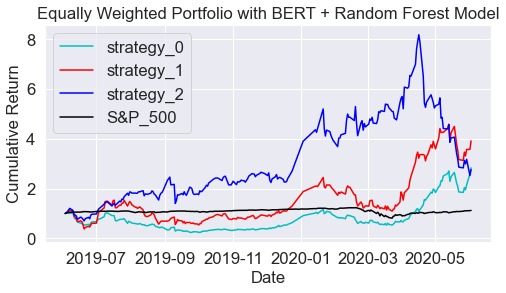

,Annualized Return,Sharp Ratio,Cumulative Return,Maximum Drawdown
Strategy_0,2.070135,1.553466,2.831135,-0.771499
Strategy_1,2.872979,1.718533,3.911559,-0.667700
Strategy_2,1.883334,1.557080,2.762673,-0.691457
S&P_500,0.165268,0.521205,1.122045,-0.341047


In [78]:
Strategy_Backtest_Equal_Weight(y_predict_BERT_RF, 'Equally Weighted Portfolio with BERT + Random Forest Model')

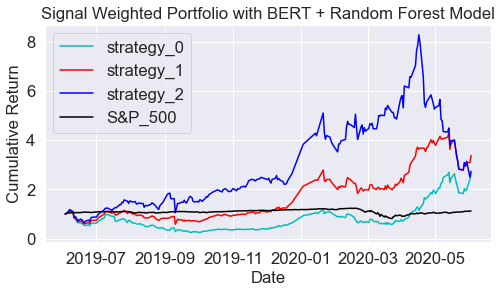

,Annualized Return,Sharp Ratio,Cumulative Return,Maximum Drawdown
Strategy_0,1.991673,1.491921,2.634885,-0.764767
Strategy_1,1.924887,1.838961,3.379464,-0.491516
Strategy_2,1.858101,1.549938,2.729117,-0.698930
S&P_500,0.165268,0.521205,1.122045,-0.341047


In [79]:
Strategy_Backtest_Signal_Weight(y_predict_BERT_RF, 'Signal Weighted Portfolio with BERT + Random Forest Model')

## 10.3 BERT + SVM [ Trade only the stock with news each day - Discrete Signals ]

In [80]:
# Compute y_predict_BERT_SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=0)
svm_model.fit(bert_w2vec_X_train, y_train)
y_predict_BERT_SVM = svm_model.predict(bert_w2vec_X_test)

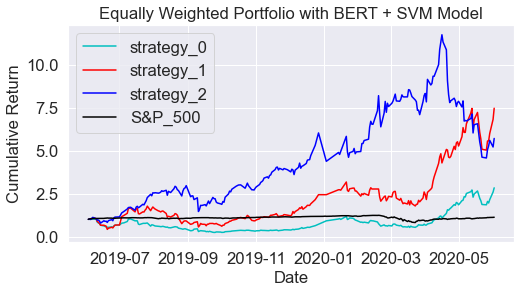

,Annualized Return,Sharp Ratio,Cumulative Return,Maximum Drawdown
Strategy_0,2.070135,1.553466,2.831135,-0.771499
Strategy_1,3.557217,2.170141,7.457647,-0.685597
Strategy_2,2.693448,2.250526,5.701298,-0.610722
S&P_500,0.165268,0.521205,1.122045,-0.341047


In [81]:
Strategy_Backtest_Equal_Weight(y_predict_BERT_SVM, 'Equally Weighted Portfolio with BERT + SVM Model')

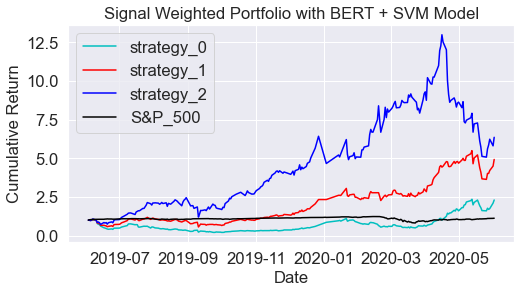

,Annualized Return,Sharp Ratio,Cumulative Return,Maximum Drawdown
Strategy_0,1.863309,1.377802,2.298536,-0.796152
Strategy_1,2.340624,2.263162,4.918682,-0.528151
Strategy_2,2.817939,2.350134,6.349890,-0.609455
S&P_500,0.165268,0.521205,1.122045,-0.341047


In [82]:
Strategy_Backtest_Signal_Weight(y_predict_BERT_SVM, 'Signal Weighted Portfolio with BERT + SVM Model')

## 10.4 BERT + RF [ Track all stocks every day - Continuous Signals ]

In [83]:
# Use one year of data for strategy testing
df_test = df.loc[test_period, ['headline','date','stock']].copy()
df_test['signal'] = y_predict_BERT_RF
df_test["signal"] = (df_test['signal'] - 1) * 2 + 1
df_test.sort_values(by=["date","stock"],inplace=True)
df_test.head()

# Voting signal for each stock
df_signa1_per_stock = df_test[['signal']].groupby([df_test['date'],df_test['stock']] ).sum().reset_index()
df_signa1_per_stock.columns = ['date', 'stock', 'signal_sum']
df_signa1_per_stock["signal_0"] = 1
df_signa1_per_stock["signal_1"] = df_signa1_per_stock["signal_sum"].apply(lambda x:1 if x>0 else 0)
df_signa1_per_stock["signal_2"] = df_signa1_per_stock["signal_sum"].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))

In [84]:
# Get the stock return for all days during test period, and merge with signals
stock_return_continue = stock_return_all.loc[(stock_return_all['date']>='2019-06-02') 
                                             & (stock_return_all['date']<='2020-06-02')].dropna()
stock_return_continue = stock_return_continue.merge(df_signa1_per_stock, how='left', on=['stock', 'date'])
stock_return_continue.fillna(1, inplace=True)

In [85]:
# Calculate daily return for each stock
stock_return_continue["return_0"] = stock_return_continue["next_day_return"] * stock_return_continue["signal_0"]
stock_return_continue["return_1"] = stock_return_continue["next_day_return"] * stock_return_continue["signal_1"]
stock_return_continue["return_2"] = stock_return_continue["next_day_return"] * stock_return_continue["signal_2"]

In [86]:
# Calculate cumulative return for each stock
stock_return_continue = (stock_return_continue[['return_0', 'return_1', 'return_2']]+1).groupby(stock_return_continue['stock']).prod()
stock_return_continue

,return_0,return_1,return_2
stock,,,
A,1.218667,1.218667,1.218667
AA,0.423429,0.462486,0.501542
AADR,1.099114,1.099114,1.099114
AAL,0.206913,0.206913,0.206913
AAME,2.656476,2.656476,2.656476
...,...,...,...
ZMLP,0.620170,0.620170,0.620170
ZSL,0.941286,0.941286,0.941286
ZTR,1.284249,1.284249,1.284249


In [87]:
# Statistics of stocks enhanced by Strategy_1, compared to the Buy and Hold Strategy_0
Strategy_1_Enhanced = (stock_return_continue.return_1>stock_return_continue.return_0).sum() / stock_return_continue.return_0.count()
Strategy_1_Same = (stock_return_continue.return_1==stock_return_continue.return_0).sum() / stock_return_continue.return_0.count()
Strategy_1_Worsen = (stock_return_continue.return_1<stock_return_continue.return_0).sum() / stock_return_continue.return_0.count()

In [88]:
# Statistics of stocks enhanced by Strategy_2, compared to the Buy and Hold Strategy_0
Strategy_2_Enhanced = (stock_return_continue.return_2>stock_return_continue.return_0).sum() / stock_return_continue.return_0.count()
Strategy_2_Same = (stock_return_continue.return_2==stock_return_continue.return_0).sum() / stock_return_continue.return_0.count()
Strategy_2_Worsen = (stock_return_continue.return_2<stock_return_continue.return_0).sum() / stock_return_continue.return_0.count()

In [89]:
df_test_statistics = pd.DataFrame(index=['Strategy_1', 'Strategy_2'], 
                                  columns=['% of Stocks Return Enhanced', '% of Stocks Return the Same', '% of Stocks Return Worsen'])
df_test_statistics.iloc[:,0] = [round(Strategy_1_Enhanced*100,4), round(Strategy_2_Enhanced*100,4)]
df_test_statistics.iloc[:,1] = [round(Strategy_1_Same*100,4), round(Strategy_2_Same*100,4)] 
df_test_statistics.iloc[:,2] = [round(Strategy_1_Worsen*100,4), round(Strategy_2_Worsen*100,4)]
df_test_statistics.index.name = 'BERT + RF Compared to Strategy_0'
df_test_statistics.T

BERT + RF Compared to Strategy_0,Strategy_1,Strategy_2
% of Stocks Return Enhanced,8.1336,8.1578
% of Stocks Return the Same,84.5074,84.5074
% of Stocks Return Worsen,7.3590,7.3348


## 10.5 BERT + SVM [ Track all stocks every day - Continuous Signals ]

In [90]:
# Use one year of data for strategy testing
df_test = df.loc[test_period, ['headline','date','stock']].copy()
df_test['signal'] = y_predict_BERT_SVM
df_test["signal"] = (df_test['signal'] - 1) * 2 + 1
df_test.sort_values(by=["date","stock"],inplace=True)
df_test.head()

# Voting signal for each stock
df_signa1_per_stock = df_test[['signal']].groupby([df_test['date'],df_test['stock']] ).sum().reset_index()
df_signa1_per_stock.columns = ['date', 'stock', 'signal_sum']
df_signa1_per_stock["signal_0"] = 1
df_signa1_per_stock["signal_1"] = df_signa1_per_stock["signal_sum"].apply(lambda x:1 if x>0 else 0)
df_signa1_per_stock["signal_2"] = df_signa1_per_stock["signal_sum"].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))

In [91]:
# Get the stock return for all days during test period, and merge with signals
stock_return_continue = stock_return_all.loc[(stock_return_all['date']>='2019-06-02')
                                             & (stock_return_all['date']<='2020-06-02')].dropna()
stock_return_continue = stock_return_continue.merge(df_signa1_per_stock, how='left', on=['stock', 'date'])
stock_return_continue.fillna(1, inplace=True)

In [92]:
# Calculate daily return for each stock
stock_return_continue["return_0"] = stock_return_continue["next_day_return"] * stock_return_continue["signal_0"]
stock_return_continue["return_1"] = stock_return_continue["next_day_return"] * stock_return_continue["signal_1"]
stock_return_continue["return_2"] = stock_return_continue["next_day_return"] * stock_return_continue["signal_2"]

In [93]:
# Calculate cumulative return for each stock
stock_return_continue = (stock_return_continue[['return_0', 'return_1', 'return_2']]+1).groupby(stock_return_continue['stock']).prod()
stock_return_continue

,return_0,return_1,return_2
stock,,,
A,1.218667,1.218667,1.218667
AA,0.423429,0.462486,0.501542
AADR,1.099114,1.099114,1.099114
AAL,0.206913,0.206913,0.206913
AAME,2.656476,2.656476,2.656476
...,...,...,...
ZMLP,0.620170,0.620170,0.620170
ZSL,0.941286,0.941286,0.941286
ZTR,1.284249,1.284249,1.284249


In [94]:
# Statistics of stocks enhanced by Strategy_1, compared to the Buy and Hold Strategy_0
Strategy_1_Enhanced = (stock_return_continue.return_1>stock_return_continue.return_0).sum() / stock_return_continue.return_0.count()
Strategy_1_Same = (stock_return_continue.return_1==stock_return_continue.return_0).sum() / stock_return_continue.return_0.count()
Strategy_1_Worsen = (stock_return_continue.return_1<stock_return_continue.return_0).sum() / stock_return_continue.return_0.count()

In [95]:
# Statistics of stocks enhanced by Strategy_2, compared to the Buy and Hold Strategy_0
Strategy_2_Enhanced = (stock_return_continue.return_2>stock_return_continue.return_0).sum() / stock_return_continue.return_0.count()
Strategy_2_Same = (stock_return_continue.return_2==stock_return_continue.return_0).sum() / stock_return_continue.return_0.count()
Strategy_2_Worsen = (stock_return_continue.return_2<stock_return_continue.return_0).sum() / stock_return_continue.return_0.count()

In [96]:
df_test_statistics = pd.DataFrame(index=['Strategy_1', 'Strategy_2'], 
                                  columns=['% of Stocks Return Enhanced', '% of Stocks Return the Same', '% of Stocks Return Worsen'])
df_test_statistics.iloc[:,0] = [round(Strategy_1_Enhanced*100,4), round(Strategy_2_Enhanced*100,4)]
df_test_statistics.iloc[:,1] = [round(Strategy_1_Same*100,4), round(Strategy_2_Same*100,4)] 
df_test_statistics.iloc[:,2] = [round(Strategy_1_Worsen*100,4), round(Strategy_2_Worsen*100,4)]

df_test_statistics.index.name = 'BERT + SVM Compared to Strategy_0'
df_test_statistics.T

BERT + SVM Compared to Strategy_0,Strategy_1,Strategy_2
% of Stocks Return Enhanced,8.3757,8.3999
% of Stocks Return the Same,84.0232,84.0232
% of Stocks Return Worsen,7.6011,7.5769
